In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

In [114]:
frequency = 110
pump_pwm = 200

Estimated oscillation frequency: 124.49 Hz


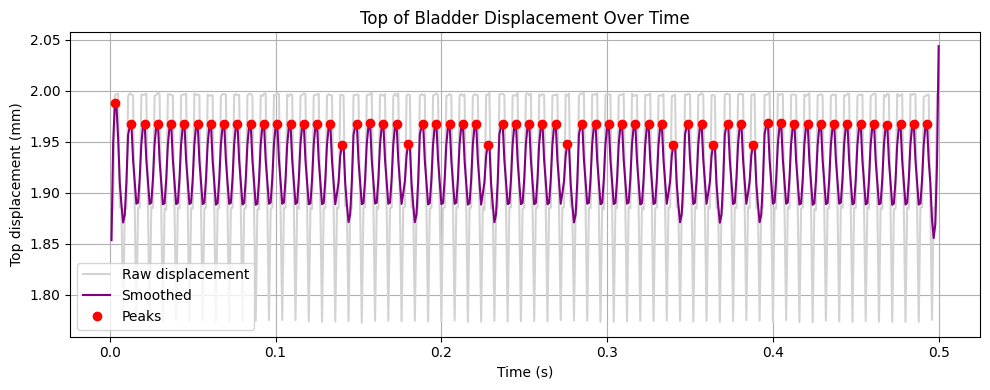

In [117]:
camera = "C001H001S0001"

base_file = str(frequency).zfill(3) + "_" + str(pump_pwm).zfill(3) + "_" + camera
folder = f"Photron Images/{base_file}/"

top_distances_mm = []
valid_times = []

fps = 1000

for img in range(1, 501):  # 1 to 500
    filename = folder + base_file + str(img).zfill(6) + ".bmp"
    if not os.path.exists(filename):
        filename = folder + base_file + str(img).zfill(6) + ".png"

    image = cv2.imread(filename)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Crop region (update if needed)
    cropped = gray[480:600, 455:535]
    color_crop = image[480:600, 455:535]

    # Preprocessing
    blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=5, threshold2=130)

    # Get edge coordinates
    edge_points = np.column_stack(np.where(edges > 0))
    if edge_points.size == 0:
        print(f"No edges found in frame {img}")
        continue

    ys = edge_points[:, 0]

    # Try to compute 3 regions
    try:
        avg_bottom_y = np.mean(ys[ys > (edges.shape[0] - 20)])
        avg_middle_y = np.mean(ys[(ys > 40) & (ys < 60)])
        peak_top_y = np.min(ys[ys < 40])

        pixels_per_mm = (avg_bottom_y - avg_middle_y) / 7.2
        top_distance_mm = (avg_middle_y - peak_top_y) / pixels_per_mm

        top_distances_mm.append(top_distance_mm)
        valid_times.append(img / fps)

    except Exception as e:
        print(f"Error in frame {img}: {e}")
        continue

# Smooth the signal
from scipy.signal import savgol_filter
smoothed = savgol_filter(top_distances_mm, window_length=11, polyorder=3)

if frequency > 100:
    prominence = 0.01
elif frequency < 10:
    prominence = 0.5
else:
    prominence = 0.1

# Find peaks in smoothed displacement
peaks, _ = find_peaks(smoothed, distance=5, height=1.8, prominence=prominence)
peak_times = np.array(valid_times)[peaks]

# Frequency estimation
if len(peak_times) > 1:
    peak_intervals = np.diff(peak_times)
    mean_period = np.mean(peak_intervals)
    oscillation_frequency = 1 / mean_period
    print(f"Estimated oscillation frequency: {oscillation_frequency:.2f} Hz")
else:
    print("Not enough peaks found to estimate frequency.")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(valid_times, top_distances_mm, label='Raw displacement', color='lightgray')
plt.plot(valid_times, smoothed, label='Smoothed', color='purple')
plt.plot(peak_times, smoothed[peaks], 'ro', label='Peaks')
plt.xlabel("Time (s)")
plt.ylabel("Top displacement (mm)")
plt.title("Top of Bladder Displacement Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Avg bottom Y: 110.90
Avg middle Y: 46.00
Peak top Y: 29
Distance from middle to top: 1.89 mm


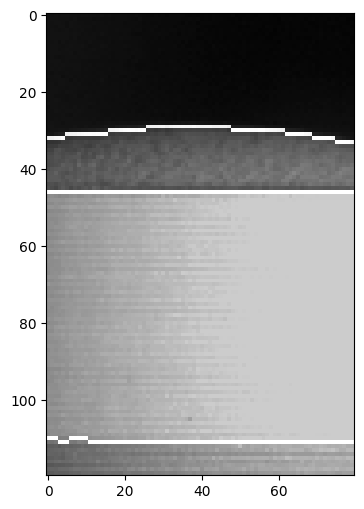

In [116]:
camera = "C001H001S0001"

base_file = str(frequency).zfill(3) + "_" + str(pump_pwm).zfill(3) + "_" + camera
folder = f"Photron Images/{base_file}/"

# Construct the base filename
file = str(frequency).zfill(3) + "_" + str(pump_pwm).zfill(3) + "_" + camera
img = 1

# Load image
filename = folder + base_file + str(img).zfill(6) + ".bmp"
if not os.path.exists(filename):
    filename = folder + base_file + str(img).zfill(6) + ".png"

image = cv2.imread(filename)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Crop region: y from 400 to 600, x from 400 to 600
cropped = gray[480:600, 455:535]
color_crop = image[480:600, 455:535]

# Apply Gaussian blur (helps with noise)
blurred = cv2.GaussianBlur(cropped, (5, 5), 0)

# Canny edge detection
edges = cv2.Canny(blurred, threshold1=40, threshold2=120)

# Overlay edges on original cropped color image
edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
overlay = cv2.addWeighted(color_crop, 0.8, edges_colored, 0.8, 0)

# Step 1: Get edge coordinates
edge_points = np.column_stack(np.where(edges > 0))  # returns [y, x] pairs

# Step 2: Split into regions
ys = edge_points[:, 0]

avg_bottom_y = np.mean(ys[ys > (edges.shape[0] - 20)])       # bottom 10 rows
avg_middle_y = np.mean(ys[(ys > 40) & (ys < 60)])            # rough middle band
peak_top_y = np.min(ys[ys < 40])                             # top arc (upper region)

# Step 3: Compute pixels/mm and top distance
pixels_per_mm = (avg_bottom_y - avg_middle_y) / 7.2
top_distance_mm = (avg_middle_y - peak_top_y) / pixels_per_mm

print(f"Avg bottom Y: {avg_bottom_y:.2f}")
print(f"Avg middle Y: {avg_middle_y:.2f}")
print(f"Peak top Y: {peak_top_y}")
print(f"Distance from middle to top: {top_distance_mm:.2f} mm")

# Plot result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
# plt.title("Canny Edges (Cropped 400:600 x 400:600)")
# plt.axis("off")
plt.show()


In [118]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, find_peaks

image_root = "Photron Images"
camera = "C001H001S0001"
pump_pwm = 200
fps = 1000

results = []

folder_list = sorted([
    f for f in os.listdir(image_root)
    if f.endswith(camera) and f.split('_')[1] == str(pump_pwm).zfill(3)
])

for folder_name in folder_list:
    try:
        frequency = int(folder_name.split('_')[0])
    except:
        print(f"Skipping malformed folder: {folder_name}")
        continue

    print(f"Processing frequency {frequency} Hz...")

    base_file = f"{str(frequency).zfill(3)}_{str(pump_pwm).zfill(3)}_{camera}"
    folder = os.path.join(image_root, base_file)

    top_distances_mm = []
    valid_times = []

    for img in range(1, 501):
        filename = os.path.join(folder, base_file + str(img).zfill(6) + ".bmp")
        if not os.path.exists(filename):
            filename = os.path.join(folder, base_file + str(img).zfill(6) + ".png")
            if not os.path.exists(filename):
                continue

        image = cv2.imread(filename)
        if image is None:
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cropped = gray[480:600, 455:535]
        blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
        edges = cv2.Canny(blurred, threshold1=5, threshold2=130)

        edge_points = np.column_stack(np.where(edges > 0))
        if edge_points.size == 0:
            continue

        ys = edge_points[:, 0]

        try:
            avg_bottom_y = np.mean(ys[ys > (edges.shape[0] - 20)])
            avg_middle_y = np.mean(ys[(ys > 40) & (ys < 60)])
            peak_top_y = np.min(ys[ys < 40])
            pixels_per_mm = (avg_bottom_y - avg_middle_y) / 7.2
            top_distance_mm = (avg_middle_y - peak_top_y) / pixels_per_mm

            top_distances_mm.append(top_distance_mm)
            valid_times.append(img / fps)
        except:
            continue

    # Frequency estimation via peaks
    disp_freq = np.nan
    if len(top_distances_mm) > 20:
        smoothed = savgol_filter(top_distances_mm, window_length=11, polyorder=3)
        if frequency > 100:
            prominence = 0.01
        elif frequency < 10:
            prominence = 0.5
        else:
            prominence = 0.1
        peaks, _ = find_peaks(smoothed, distance=5, height=1.8, prominence=prominence)
        peak_times = np.array(valid_times)[peaks]

        if len(peak_times) > 1:
            intervals = np.diff(peak_times)
            mean_period = np.mean(intervals)
            disp_freq = 1 / mean_period

    results.append({
        "valve_freq_hz": frequency,
        "disp_freq_hz": disp_freq
    })
    print(f"Frequency: {frequency} Hz, Disp. Frequency: {disp_freq:.2f} Hz")

# Create DataFrame
df = pd.DataFrame(results)
df = df.sort_values("valve_freq_hz").reset_index(drop=True)
print(df)


Processing frequency 0 Hz...
Frequency: 0 Hz, Disp. Frequency: nan Hz
Processing frequency 5 Hz...
Frequency: 5 Hz, Disp. Frequency: 5.00 Hz
Processing frequency 10 Hz...
Frequency: 10 Hz, Disp. Frequency: 9.90 Hz
Processing frequency 15 Hz...
Frequency: 15 Hz, Disp. Frequency: 15.18 Hz
Processing frequency 20 Hz...
Frequency: 20 Hz, Disp. Frequency: 20.00 Hz
Processing frequency 25 Hz...
Frequency: 25 Hz, Disp. Frequency: 25.00 Hz
Processing frequency 30 Hz...
Frequency: 30 Hz, Disp. Frequency: 31.25 Hz
Processing frequency 35 Hz...
Frequency: 35 Hz, Disp. Frequency: 35.71 Hz
Processing frequency 40 Hz...
Frequency: 40 Hz, Disp. Frequency: 41.49 Hz
Processing frequency 45 Hz...
Frequency: 45 Hz, Disp. Frequency: 45.36 Hz
Processing frequency 50 Hz...
Frequency: 50 Hz, Disp. Frequency: 50.00 Hz
Processing frequency 55 Hz...


KeyboardInterrupt: 